# ANOMALY DETECTION WITH T-SNE

#### In this notebook, we will analyze real data provided during the ENGIE Datapower Hackathon, containing 2.5 millions sensor measurements

#### You can find a full blog post about this notebook [here](https://medium.com/@Zelros/anomaly-detection-with-t-sne-211857b1cd00#.v3rssyf9a)

In [105]:
import pandas as pd
import numpy as np
from datetime import datetime
from pylab import rcParams
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
import mpld3

#### Let's load the data and have a look at it ...

In [81]:
alldata = pd.read_csv('Cockpit_Hackathon_indicateurs.csv')
alldata['SITE_ID'].value_counts()

47    739044
38    540109
Name: SITE_ID, dtype: int64

#### Each row of the dataset is a sensor measurement

In [82]:
alldata.head()

,SITE_ID,INDIC_ID,VALEUR,DATETIME
0,47,33131,21.343443,2015-09-27 23:00:00
1,47,33131,33.362208,2015-09-28 00:00:00
2,47,33131,26.267952,2015-09-28 01:00:00
3,47,33131,22.197266,2015-09-28 02:00:00
4,47,33131,24.273399,2015-09-28 03:00:00


#### We reshape the dataset to put one column per sensor, and focus on site 47

In [83]:
data = alldata[alldata['SITE_ID'] == 47].pivot(index='DATETIME', columns='INDIC_ID', values='VALEUR')

In [84]:
data.head()

INDIC_ID,8790,8816,8817,8822,10456,10464,10625,10808,10840,10848,...,31029,31031,31043,31048,31067,33131,33151,33171,33175,36342
DATETIME,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,79.960001,104.432501,21.173750,60.482501,84.742501,90.391666,6.500,46.210000,53.480833,49.765000,...,3.2,0.028937,0.04113,0.278819,NaN,NaN,NaN,NaN,NaN,1.25
2015-01-01 01:00:00,80.807499,105.202501,41.866251,62.517500,88.114999,90.919168,7.005,46.839166,53.730834,49.764167,...,3.2,0.028937,0.04113,0.278819,NaN,NaN,NaN,NaN,NaN,1.25
2015-01-01 02:00:00,82.301249,106.150000,82.116248,90.247500,85.659998,86.661667,9.740,47.489999,53.689167,49.763333,...,3.2,0.028937,0.04113,0.278819,NaN,NaN,NaN,NaN,NaN,1.25
2015-01-01 03:00:00,82.155001,104.030001,82.043751,99.287498,84.305833,85.748334,8.205,48.272500,51.793333,49.660000,...,3.2,0.028937,0.04113,0.278819,NaN,NaN,NaN,NaN,NaN,1.25
2015-01-01 04:00:00,80.596249,102.075002,80.641249,81.317500,79.275835,84.859166,12.305,48.885000,54.063333,50.276667,...,3.2,0.028937,0.04113,0.278819,NaN,NaN,NaN,NaN,NaN,1.25


#### We make some timestamp conversion

In [85]:
data.index = [datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in data.index]

#### We focus on year 2015 for this study

In [86]:
data = data.loc['20150101':'20151231']

#### Now load the description of each sensor

In [87]:
description = pd.read_csv('Liste_indicateurs.csv')
labels = description[['INDIC_ID', 'DESCRIPTION']].set_index('INDIC_ID').to_dict()['DESCRIPTION']
description.head()

,INDIC_ID,DESCRIPTION,UNIT_ID,EQUIPEMENT_ID,SITE_ID
0,1586,Temperature Eau Entree Chaudiere(s) [CH1],DEG,EQUIPEMENT-CH1 - GAZ FOL (30 MW),38
1,1600,Temperature Eau Entree Chaudiere(s) [CH4],DEG,EQUIPEMENT-CH4 - GAZ FOD (15 MW),38
2,1604,Temperature Eau Entree Chaudiere(s) [CH2],DEG,EQUIPEMENT-CH2 - GAZ FOL (30 MW),38
3,5356,Temperature Fumees Sortie Turbine,DEG,EQUIPEMENT-A supprimer,38
4,14894,Compteur Horaire [TAG],H,DOSSIER-Autres parametres TAG,38


# Let's have a look at some sensors data 

#### Left is 1 year span. Right is 1 week span

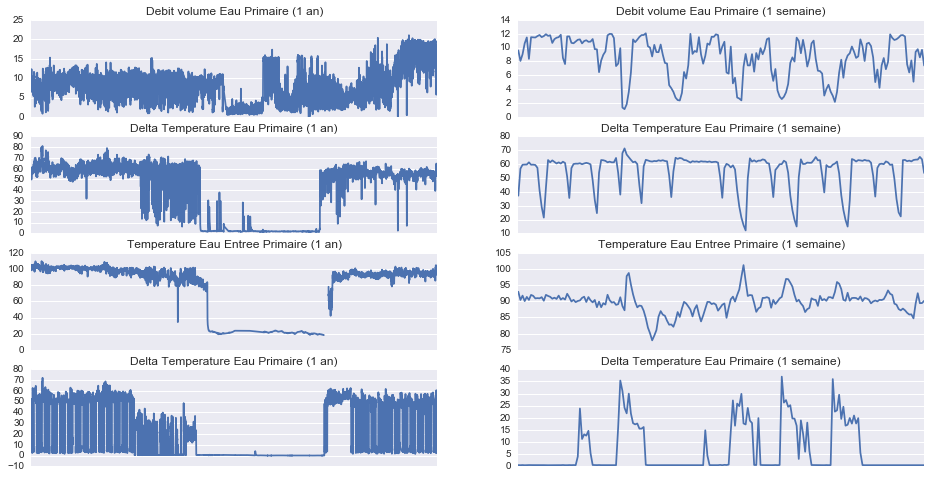

In [88]:
fig = plt.figure(figsize=(16, 8)) 
for i, sensor in enumerate([10625, 21461, 11335, 21458]) : 
    plt.subplot(4,2,2*i+1)
    plt.title(labels[sensor] + ' (1 an)')
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.plot(list(data[sensor]))
    plt.subplot(4,2,2*i+2)
    plt.title(labels[sensor] + ' (1 semaine)')
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.plot(list(data[sensor].loc['20150502':'20150509']))

#### Each sensor has a very different profile ...

# Are some captors correlated (positively or negatively) ?

/Users/christophebourguignat/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/christophebourguignat/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


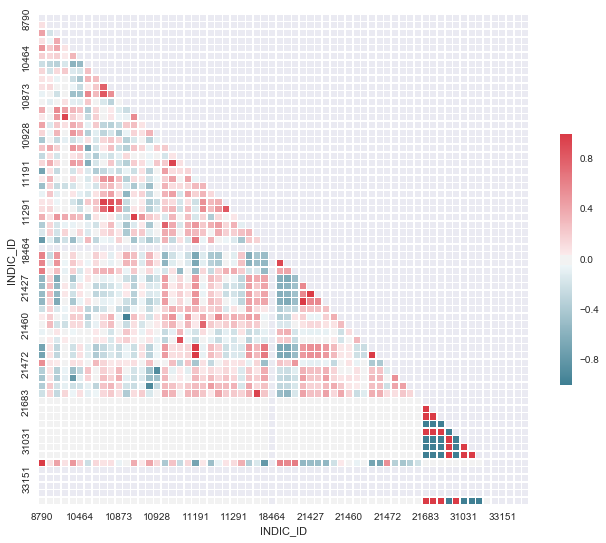

In [89]:
corr = data.loc['20150502':'20150509'].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#### Indeed some sensors are correlated. For exemple sensors 31067 and 8790 are very correlated. Let's have a look at them

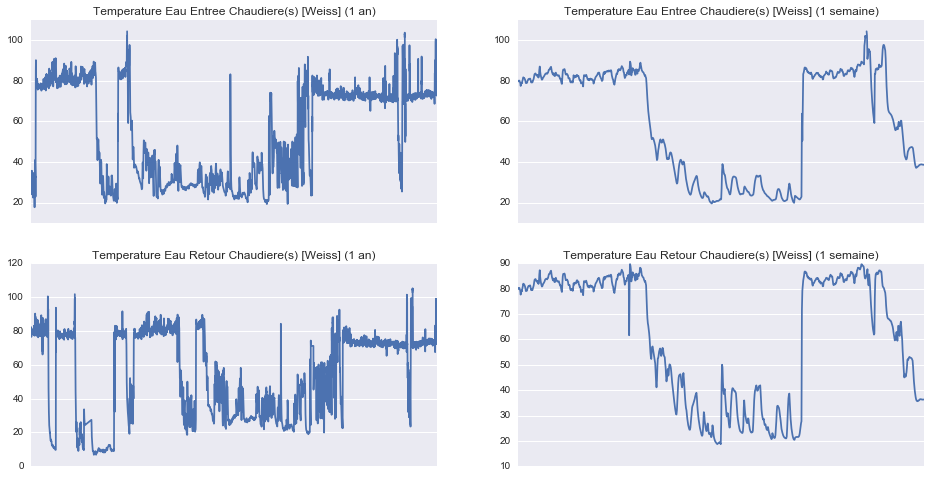

In [90]:
fig = plt.figure(figsize=(16, 8)) 
plt.subplot(221)
plt.title(labels[31067] + ' (1 an)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.plot(list(data[31067]))
plt.subplot(222)
plt.title(labels[31067] + ' (1 semaine)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.plot(list(data[31067].loc['20150502':'20150609']))
plt.subplot(223)
plt.title(labels[8790] + ' (1 an)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.plot(list(data[8790]))
plt.subplot(224)
plt.title(labels[8790] + ' (1 semaine)')
plt.gca().axes.get_xaxis().set_ticks([])
plt.plot(list(data[8790].loc['20150502':'20150609']))

#### A human can not detect anomalies in these signals, by explicitely hard-coding alerting rules.
#### What is a normal behaviour ? What is an anomaly ? 
#### There is so much data that a human cannot easily diagnose and predict anomalies by himself ...

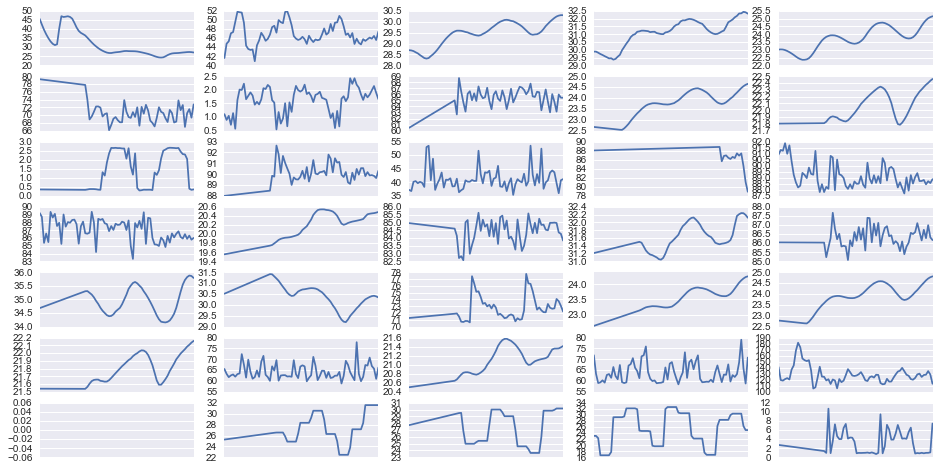

In [91]:
fig = plt.figure(figsize=(16, 8)) 
for i, c in enumerate(data.columns.values[:35]):
    plt.subplot(7,5,i+1)
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.plot(list(data[c].loc['20150626':'20150628']))

# Clustering and spotting anomalies

#### Before clustering, we will shuffle data and replace missing values (which can be considered as an anomaly) with random

In [92]:
permut = np.random.permutation(data.index)
datashuf = data.reindex(permut).fillna(method='ffill').fillna(method='bfill')

#### We have dozens of sensors. As humans cannot see in more than 3 dimensions, we will reduce dimension to 2D and clusterize obervations to visualize structure of the Data.

In [93]:
MIN = 4700
MAX = 9000
ts = TSNE(2)
reduced1 = ts.fit_transform(datashuf[MIN:MAX])

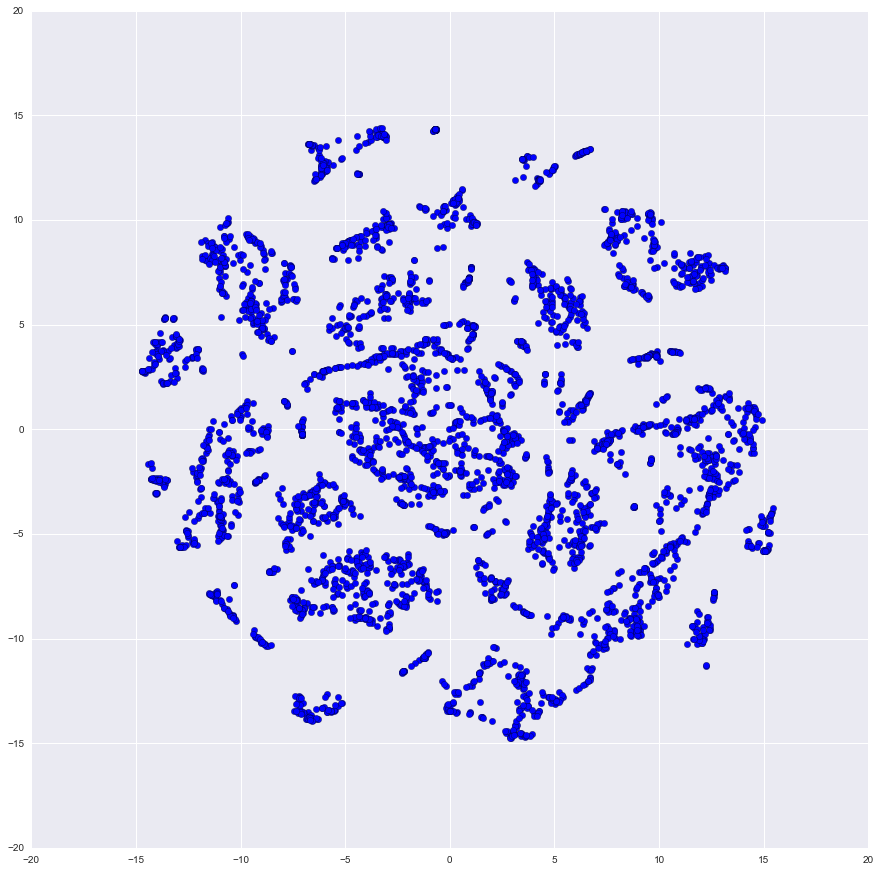

In [94]:
rcParams['figure.figsize'] = 15, 15
fig, ax = plt.subplots()
scatter = ax.scatter(reduced1[:,0],
                     reduced1[:,1],
                     cmap=plt.cm.PuOr,
                     s=40)

#### Each point of this graph is a a measurement of all sensors at a given moment

#### We can see clusters, group of points. What are they ? Are they hours ? To know that, we will colour each point depending on its hour

In [95]:
colvals = [dt.hour for dt in datashuf[MIN:MAX].index]
minima = min(colvals)
maxima = max(colvals)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)
mycolors = [mapper.to_rgba(v) for v in colvals]

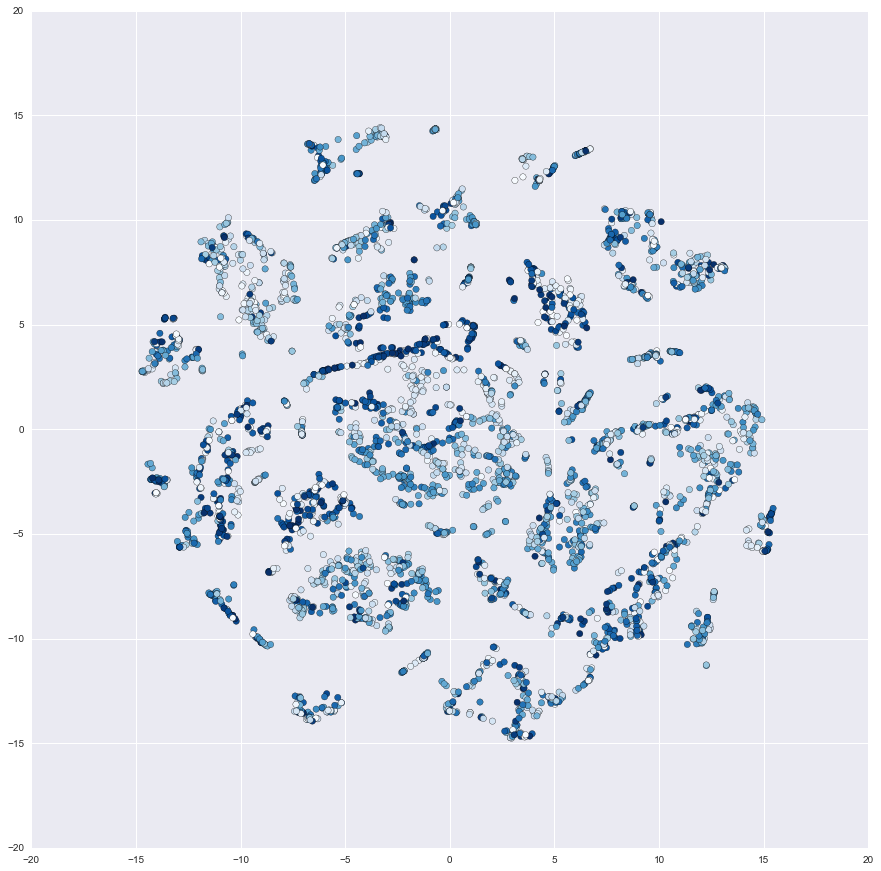

In [96]:
rcParams['figure.figsize'] = 15, 15
fig, ax = plt.subplots()
scatter = ax.scatter(reduced1[:,0],
                     reduced1[:,1],
                    c=mycolors,
                     cmap=plt.cm.PuOr,
                     s=40)

#### Colors are not grouped. So no, the clusters are not hours.

#### Maybe the clusters are days of the week ? Let's colour each point with the day of the week

In [97]:
colvals = [dt.weekday() for dt in datashuf[MIN:MAX].index]
minima = min(colvals)
maxima = max(colvals)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)
mycolors = [mapper.to_rgba(v) for v in colvals]

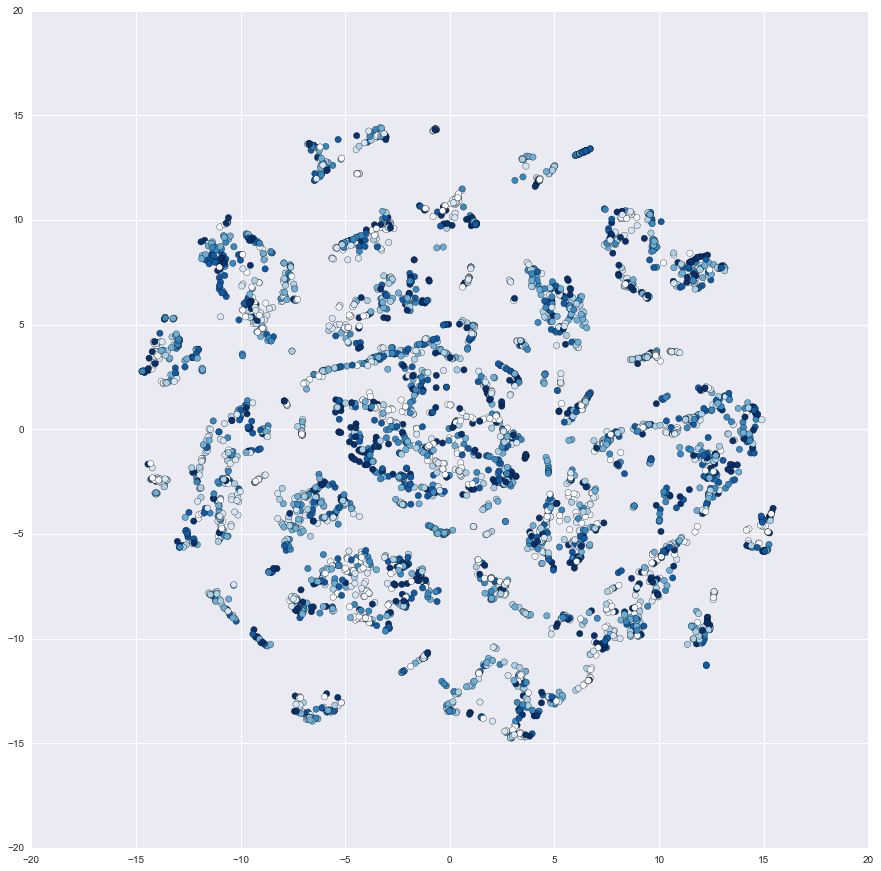

In [98]:
rcParams['figure.figsize'] = 15, 15
fig, ax = plt.subplots()
scatter = ax.scatter(reduced1[:,0],
                     reduced1[:,1],
                    c=mycolors,
                     cmap=plt.cm.PuOr,
                     s=40)

#### Again, colors are not grouped. So no, the clusters are not days of the week.

#### Maybe the clusters are periods of the year ? Let's try to colour each point with its day in the year

In [99]:
colvals = [dt.timetuple().tm_yday for dt in datashuf[MIN:MAX].index]
minima = min(colvals)
maxima = max(colvals)
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Blues_r)
mycolors = [mapper.to_rgba(v) for v in colvals]

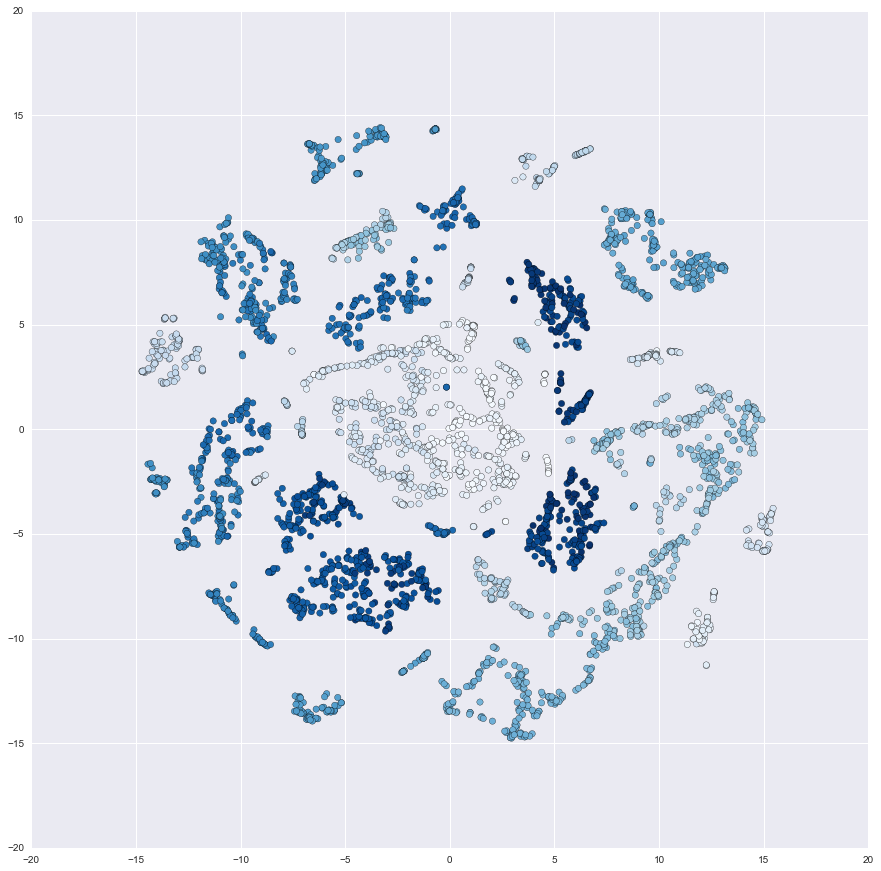

In [106]:
rcParams['figure.figsize'] = 15, 15
fig, ax = plt.subplots()
scatter = ax.scatter(reduced1[:,0],
                     reduced1[:,1],
                     c=mycolors,
                     cmap=plt.cm.PuOr,
                     s=40)
#tooltip = mpld3.plugins.PointHTMLTooltip(scatter, labels=[str(i) for i in datashuf[MIN:MAX].index])
#mpld3.plugins.connect(fig, tooltip)
#mpld3.display()

#### Yes ! Observations close in the year are close in the cluster !

#### We are now able to spot abnormal points : those with color that do not correspond to their cluster. They are anomalies

# We have a strange out of cluster point on 4/12 at 4pm. Let's have a look at it

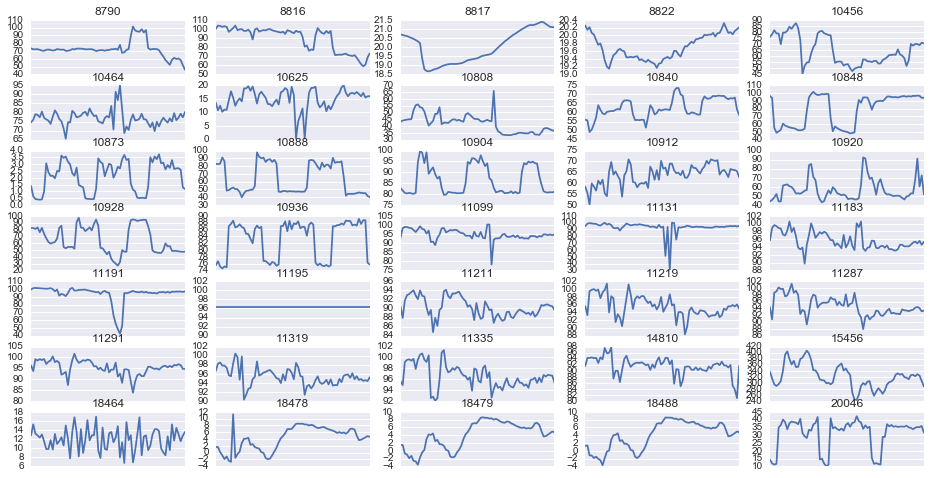

In [101]:
fig = plt.figure(figsize=(16, 8)) 
for i, c in enumerate(data.columns.values[:35]):
    plt.subplot(7,5,i+1)
    plt.title(c)
    plt.gca().axes.get_xaxis().set_ticks([])
    #plt.plot(list(data[c].loc['20151203':'20151205']))
    plt.plot(list(datashuf[c].sort_index().loc['20151203':'20151205']))

#### Zoom on sensor 11099 : indeed we see an anomaly at this moment !

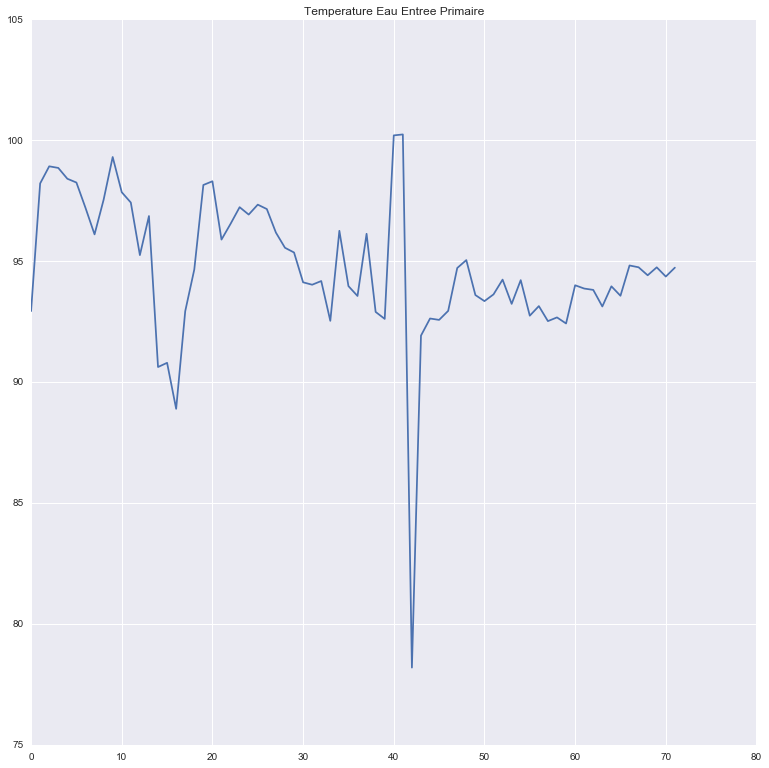

In [102]:
plt.plot(list(datashuf[11099].sort_index().loc['20151203':'20151205']))
plt.title(labels[11099])

# Other example : we have a strange out of cluster point on 6/11 at 2pm. Let's have a look at it

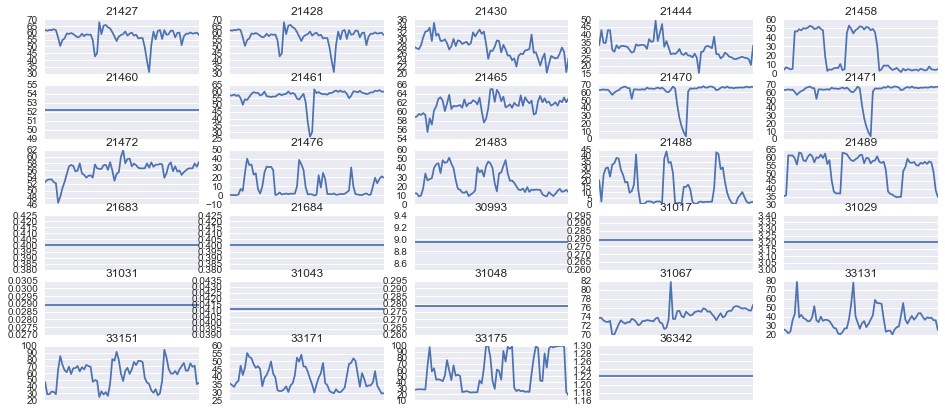

In [103]:
fig = plt.figure(figsize=(16, 8)) 
for i, c in enumerate(data.columns.values[35:]):
    plt.subplot(7,5,i+1)
    plt.title(c)
    plt.gca().axes.get_xaxis().set_ticks([])
    plt.plot(list(datashuf[c].sort_index().loc['20151105':'20151107']))

#### Zoom on sensor 21470 : indeed we see an anomaly at this moment !

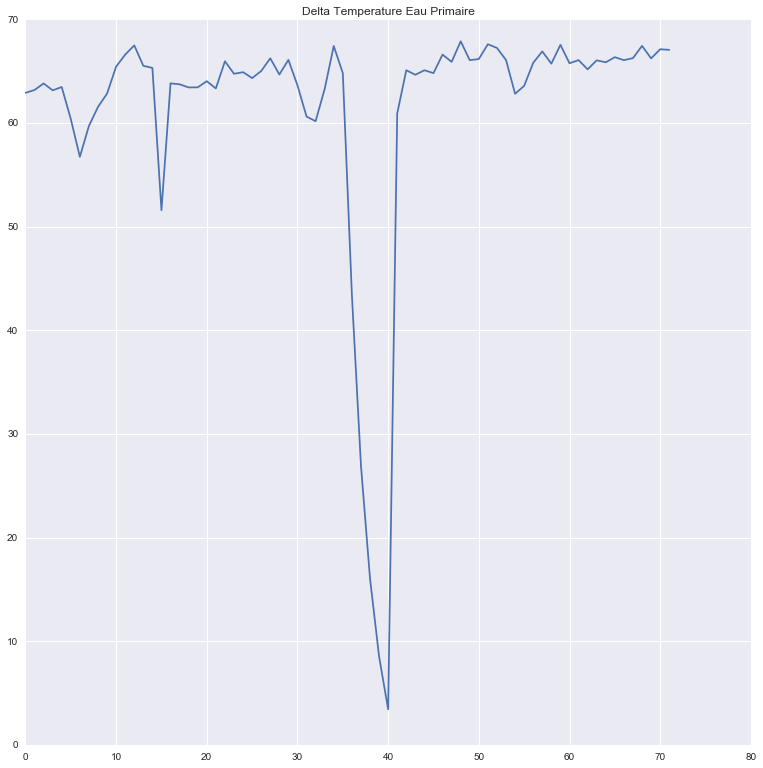

In [104]:
plt.plot(list(datashuf[21470].sort_index().loc['20151105':'20151107']))
plt.title(labels[21470])

# Conclusion

#### By using advanced unsupervised learning technics, we were able to spot anomalies in data.

#### This could be used to detect high-risk assets or sensors, before they fail. This is a new way to assess in real-time infrastructure behaviour, and anticipate risks.